# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import math
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Applied Ai/Datasets/Amazon food reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#sorting the final values by time to do  time based splitting

final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [19]:
with open('final.pkl','wb') as f :
    pickle.dump(final,f)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to f

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [01:34<00:00, 3852.85it/s]


In [25]:
#now taking 100000 points 
y=np.array(final["Score"])[:100000]
X=preprocessed_reviews[:100000]


In [26]:
with open('y.pkl','wb') as f :
    pickle.dump(y,f)
with open('preprocessed_reviews.pkl','wb') as f :
    pickle.dump(X,f)


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 1


In [1]:
import pickle
with open('y.pkl','rb') as f :
    y=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    X=pickle.load(f)


In [2]:
from sklearn.model_selection import train_test_split

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 100000 )
tokenizer.fit_on_texts(X_tr)


Using TensorFlow backend.


In [4]:
X_tr  = tokenizer.texts_to_sequences(X_tr)

X_test  = tokenizer.texts_to_sequences(X_test)

In [8]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.layers.embeddings import Embedding

In [9]:
### applyting padding
max_review_length = 600
X_tr = pad_sequences(X_tr, maxlen=max_review_length)
X_test =  pad_sequences(X_test, maxlen=max_review_length)

print(X_tr.shape)
print(X_tr[1])

(80000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

### Utility functions

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    #plt.show()
    fig.canvas.draw()

In [11]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [12]:
#plotting the confusing matrix heatmap
def con_mat(y_actual,y_pr):
    y_pred=[]
    for i in y_pr:
        y_pred.append(i[0])
        
    class_names = ['negative','positive']
    df_heatmap_bow = pd.DataFrame(confusion_matrix(y_actual,y_pred), index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,4))
    heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('Predicted label',size=18)
    plt.xlabel('True label',size=18)
    plt.title("Test-Confusion-Matrix",size=24)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


In [15]:
vocab_size = len(tokenizer.word_index)
vocab_size

52992

### 1 layer LSTM

In [16]:
# create the model
embedding_vec_length = 32

# Initialising the model
m_1 = Sequential()

# Adding embedding
m_1.add(Embedding(vocab_size+1, embedding_vec_length, input_length=max_review_length))


# Adding first LSTM layer
m_1.add(LSTM(100))

# Adding Dropout
m_1.add(Dropout(0.5))

# Adding output layer
m_1.add(Dense(1, activation='sigmoid'))


m_1.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           1695776   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,749,077
Trainable params: 1,749,077
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compiling the model
m_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = m_1.fit(X_tr, y_tr, nb_epoch=10, batch_size=64 ,verbose=1,validation_data=(X_test, y_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 804s 10ms/step - loss: 0.2219 - accuracy: 0.9180 - val_loss: 0.1800 - val_accuracy: 0.9320
Epoch 2/10
80000/80000 [==============================] - 816s 10ms/step - loss: 0.1420 - accuracy: 0.9484 - val_loss: 0.1804 - val_accuracy: 0.9319
Epoch 3/10
80000/80000 [==============================] - 807s 10ms/step - loss: 0.1116 - accuracy: 0.9604 - val_loss: 0.1889 - val_accuracy: 0.9317
Epoch 4/10
80000/80000 [==============================] - 796s 10ms/step - loss: 0.0871 - accuracy: 0.9700 - val_loss: 0.2007 - val_accuracy: 0.9315
Epoch 5/10
80000/80000 [==============================] - 785s 10ms/step - loss: 0.0653 - accuracy: 0.9776 - val_loss: 0.2570 - val_accuracy: 0.9281
Epoch 6/10
80000/80000 [==============================] - 444s 6ms/step - loss: 0.0503 - accuracy: 0.9836 - val_loss: 0.2634 - val_accuracy: 0.9291
Epoch 7/10
80000/80000 [==============================] -

In [55]:
tf.keras.backend.clear_session()

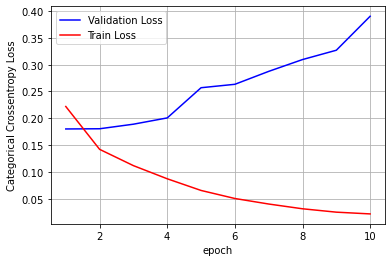

In [18]:
### Plotting train and test curve
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)


In [19]:
score = m_1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


Test loss: 0.3903583525273018
Test accuracy: 0.9214500188827515


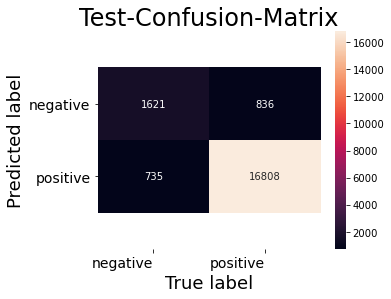

In [20]:
y_pred=m_1.predict_classes(X_test)
con_mat(y_test,y_pred)

### 2-layer LSTMS

In [21]:

# create the model
embedding_vec_length = 32

# Initialising the model
m_2 = Sequential()

# Adding embedding
m_2.add(Embedding(vocab_size+1, embedding_vec_length, input_length=max_review_length))

# Adding first LSTM layer
m_2.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding second LSTM layer
m_2.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
m_2.add(Dropout(0.5))

# Adding output layer
m_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(m_2.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           1695776   
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,829,477
Trainable params: 1,829,477
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
#increasing the batch size due to reduce the computational complexity
m_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = m_2.fit(X_tr, y_tr, nb_epoch=10, batch_size=128 ,verbose=1,validation_data=(X_test, y_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 1017s 13ms/step - loss: 0.1806 - accuracy: 0.9329 - val_loss: 0.1866 - val_accuracy: 0.9275
Epoch 2/10
80000/80000 [==============================] - 976s 12ms/step - loss: 0.1616 - accuracy: 0.9414 - val_loss: 0.1903 - val_accuracy: 0.9297
Epoch 3/10
80000/80000 [==============================] - 688s 9ms/step - loss: 0.1431 - accuracy: 0.9484 - val_loss: 0.1925 - val_accuracy: 0.9319
Epoch 4/10
80000/80000 [==============================] - 684s 9ms/step - loss: 0.1318 - accuracy: 0.9531 - val_loss: 0.1948 - val_accuracy: 0.9301
Epoch 5/10
80000/80000 [==============================] - 683s 9ms/step - loss: 0.1219 - accuracy: 0.9566 - val_loss: 0.1941 - val_accuracy: 0.9306
Epoch 6/10
80000/80000 [==============================] - 693s 9ms/step - loss: 0.1124 - accuracy: 0.9603 - val_loss: 0.2187 - val_accuracy: 0.9301
Epoch 7/10
80000/80000 [==============================] - 6

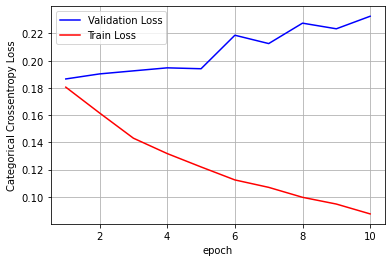

In [91]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))
vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)


In [92]:
score = m_2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


Test loss: 0.23267174651324748
Test accuracy: 0.9285500049591064


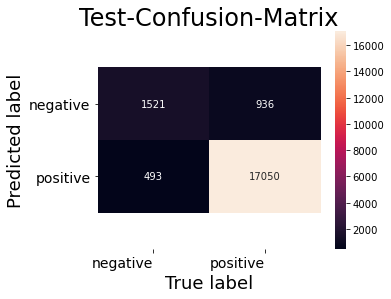

In [93]:
y_pred=m_2.predict_classes(X_test)
con_mat(y_test,y_pred)

### 3-Layer LSTM

In [11]:
# create the model
embedding_vec_length = 32

# Initialising the model
m_3 = Sequential()

# Adding embedding
m_3.add(Embedding(vocab_size+1, embedding_vec_length, input_length=max_review_length))

# Adding first LSTM layer
m_3.add(LSTM(100,return_sequences=True, dropout=0.4 ,recurrent_dropout=0.4))

# Adding second LSTM layer
m_3.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Adding third LSTM layer
m_3.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
m_3.add(Dropout(0.5))

# Adding output layer
m_3.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(m_3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           3173952   
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,388,053
Trainable params: 3,388,053
Non-trainable params: 0
____________________________________________

In [12]:
m_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_3 = m_3.fit(X_tr, y_tr, nb_epoch=10, batch_size=128 ,verbose=1,validation_data=(X_test, y_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 685s 9ms/step - loss: 0.2627 - accuracy: 0.9043 - val_loss: 0.1996 - val_accuracy: 0.9212
Epoch 2/10
80000/80000 [==============================] - 681s 9ms/step - loss: 0.1819 - accuracy: 0.9336 - val_loss: 0.1855 - val_accuracy: 0.9294
Epoch 3/10
80000/80000 [==============================] - 682s 9ms/step - loss: 0.1732 - accuracy: 0.9345 - val_loss: 0.1901 - val_accuracy: 0.9277
Epoch 4/10
80000/80000 [==============================] - 684s 9ms/step - loss: 0.1512 - accuracy: 0.9444 - val_loss: 0.2292 - val_accuracy: 0.9284
Epoch 5/10
80000/80000 [==============================] - 703s 9ms/step - loss: 0.1372 - accuracy: 0.9506 - val_loss: 0.1978 - val_accuracy: 0.9292
Epoch 6/10
80000/80000 [==============================] - 713s 9ms/step - loss: 0.1285 - accuracy: 0.9546 - val_loss: 0.2012 - val_accuracy: 0.9269
Epoch 7/10
80000/80000 [==============================] - 718s

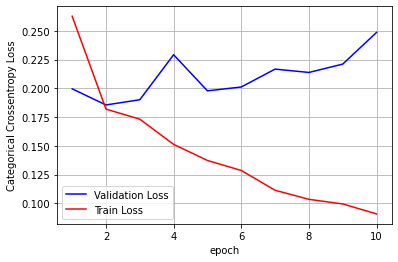

In [13]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))
vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)


In [14]:
score = m_3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


Test loss: 0.2486444657607004
Test accuracy: 0.9284499883651733


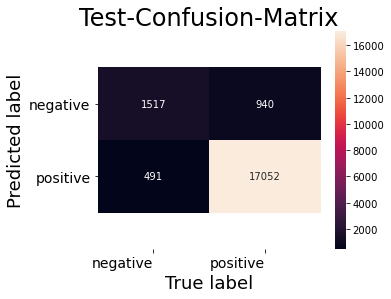

In [16]:
y_pred=m_3.predict_classes(X_test)
con_mat(y_test,y_pred)

In [15]:
from prettytable import PrettyTable
import numpy as np

Model= ['1 LSTM Layer','2 LSTM Layers','3 LSTM Layers']

# Training accuracies

# Test accuracies
test_acc = [0.910, 0.9285,0.9284]
test_loss=[0.38,0.23,0.24]

n = np.arange(1,4)

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",n)
table.add_column("MODEL",Model)
table.add_column("Test-Loss",test_loss)
table.add_column("Test-Accuracy",test_acc)

# Printing the Table
print(table)

+-------+---------------+-----------+---------------+
| S.NO. |     MODEL     | Test-Loss | Test-Accuracy |
+-------+---------------+-----------+---------------+
|   1   |  1 LSTM Layer |    0.38   |      0.91     |
|   2   | 2 LSTM Layers |    0.23   |     0.9285    |
|   3   | 3 LSTM Layers |    0.24   |     0.9284    |
+-------+---------------+-----------+---------------+


###  Summary

1)LSTM with 2 layers gives us the best accuracy with least loss
2)with 10 Epochs  models are overfitting as we can see from the graphs above ,maybe increasing the number of epochs or using some regularization techniques might reduce the overfitting 
